In [1]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
clfile = os.path.join('..','src','glm_gpu','cl','logistic.cl')
os.path.isfile(clfile)

True

In [299]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
device = pcl.get_platforms()[0].get_devices()[2]
cntx = pcl.Context([device])
queue = pcl.CommandQueue(cntx)

with open(clfile, 'r') as f:
    programs = pcl.Program(cntx, f.read()).build()

/Users/antalek/anaconda/envs/ENVPy3/lib/python3.5/site-packages/pyopencl/cffi_cl.py:1472: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'AMD Radeon R9 M370X Compute Engine' on 'Apple' at 0x1021c00> succeeded, but said:

<program source>:23:9: warning: unused variable 'sig'
  float sig = 1.0f / exponential;
        ^

  warn(text, CompilerWarning)


In [300]:
device.name

'AMD Radeon R9 M370X Compute Engine'

In [301]:
theta = np.array([0.5, 0.5], dtype=np.float32)

In [302]:
theta.dtype

dtype('float32')

In [303]:
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

In [304]:
nsamps=1

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


In [305]:
X_all = pd.concat((X_1, X_0), ignore_index=True)

In [306]:
X_all = X_all.reindex(np.random.permutation(X_all.index))

In [307]:
X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [308]:
X.values

array([[ 11.85348129,   7.90722942],
       [  8.44975948,  -3.08361173]], dtype=float32)

In [309]:
cost_arr = np.zeros(shape=(X.shape[0],)).astype(np.float32)
temp_avg = np.zeros(shape=(4,)).astype(np.float32)

In [310]:
# compute cost
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)

theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)

cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
temp_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=temp_avg.nbytes)
scratch_buf = pcl.LocalMemory(np.float32().nbytes * 256)

nrows = np.int32(X.shape[0])
ncols = np.int32(X.shape[1])

out = np.zeros(shape=(X.shape[0],), dtype=np.float32)
out_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=out.nbytes)

In [311]:
sig_event = programs.sig(queue,
                         X.shape,
                         None,
                         X_buf,
                         theta_buf,
                         out_buf,
                         nrows,
                         ncols)

# cost_event = programs.logistic_cost_ols(queue,
#                                         X.shape,
#                                         None,
#                                         X_buf,
#                                         theta_buf,
#                                         y_buf,
#                                         cost_buf,
#                                         nrows,
#                                         ncols)

# reduction_event = programs.matrix_row_mean(queue,
#                                            (1024,),
#                                            (256,),
#                                            cost_buf,
#                                            temp_buf,
#                                            scratch_buf,
#                                            nrows,
#                                            np.int32(1))

In [312]:
nrows, ncols, theta.shape

(2, 2, (2,))

In [313]:



sig_event.wait()
pcl.enqueue_copy(queue, out, out_buf).wait()

# cost_event.wait()
# pcl.enqueue_copy(queue, cost_arr, cost_buf).wait()

# reduction_event.wait()
# pcl.enqueue_copy(queue, temp_avg, temp_buf).wait()


In [314]:
def sig(X, theta):
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def cost(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    cost = cost.sum()
    return cost

In [315]:
my_out = sig(X.values, theta)

In [316]:
my_out.shape, out.shape

((2,), (2,))

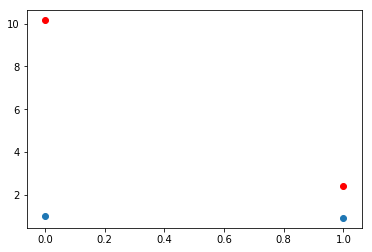

In [317]:
x = list(range(len(my_out)))
plt.scatter(x, my_out)
plt.scatter(x, out, color='r')
plt.show()


In [318]:
X.values.dot(theta)

array([ 9.88035583,  2.683074  ], dtype=float32)

In [287]:
out == my_out

array([False, False, False, False], dtype=bool)

In [288]:
out

array([ 0.99969804,  0.99987626,  0.28631127,  0.37530953], dtype=float32)

In [289]:
my_out

array([ 0.51509088,  0.99920076,  0.9987852 ,  0.85520339], dtype=float32)

In [211]:
out -= 1.0

In [213]:
np.e == out

array([ True,  True,  True,  True], dtype=bool)